In [ ]:
!pip install ccxt



🚀 АНАЛИЗ BITCOIN HALVING С OHLC ДАННЫМИ
📥 Получение данных Bitstamp...
  ⏳ Загрузка исторических данных (2012-2025)...
    ✓ Загружено 6,846,600 записей
  ⏳ Загрузка последних обновлений...
    ✓ Загружено 444,999 записей

✓ Всего загружено 7,291,599 свечей
  Диапазон: 2012-01-01 - 2025-11-12

📊 Преобразование данных в 1W OHLC...
✓ Преобразовано в 725 свечей 1W

📊 СТАТИСТИКА ДАННЫХ

Всего свечей (недельных): 725
Первая свеча: 2012-01-01
Последняя свеча: 2025-11-16

Пока цены (в USD):
  Минимум: $3.80
  Максимум: $126,272.00
  Текущая: $102,862.00

Объем торговли (недельный, в BTC):
  Средний: 51,677.25
  Минимум: 10.00
  Максимум: 390,367.56


🎨 Построение графика...
  Рисую свечи...
  Добавляю разметку халфингов...
  Рисую объёмы...
  Сохраняю график...
✓ График сохранён: /mnt/user-data/outputs/bitcoin_weekly_ohlc.png


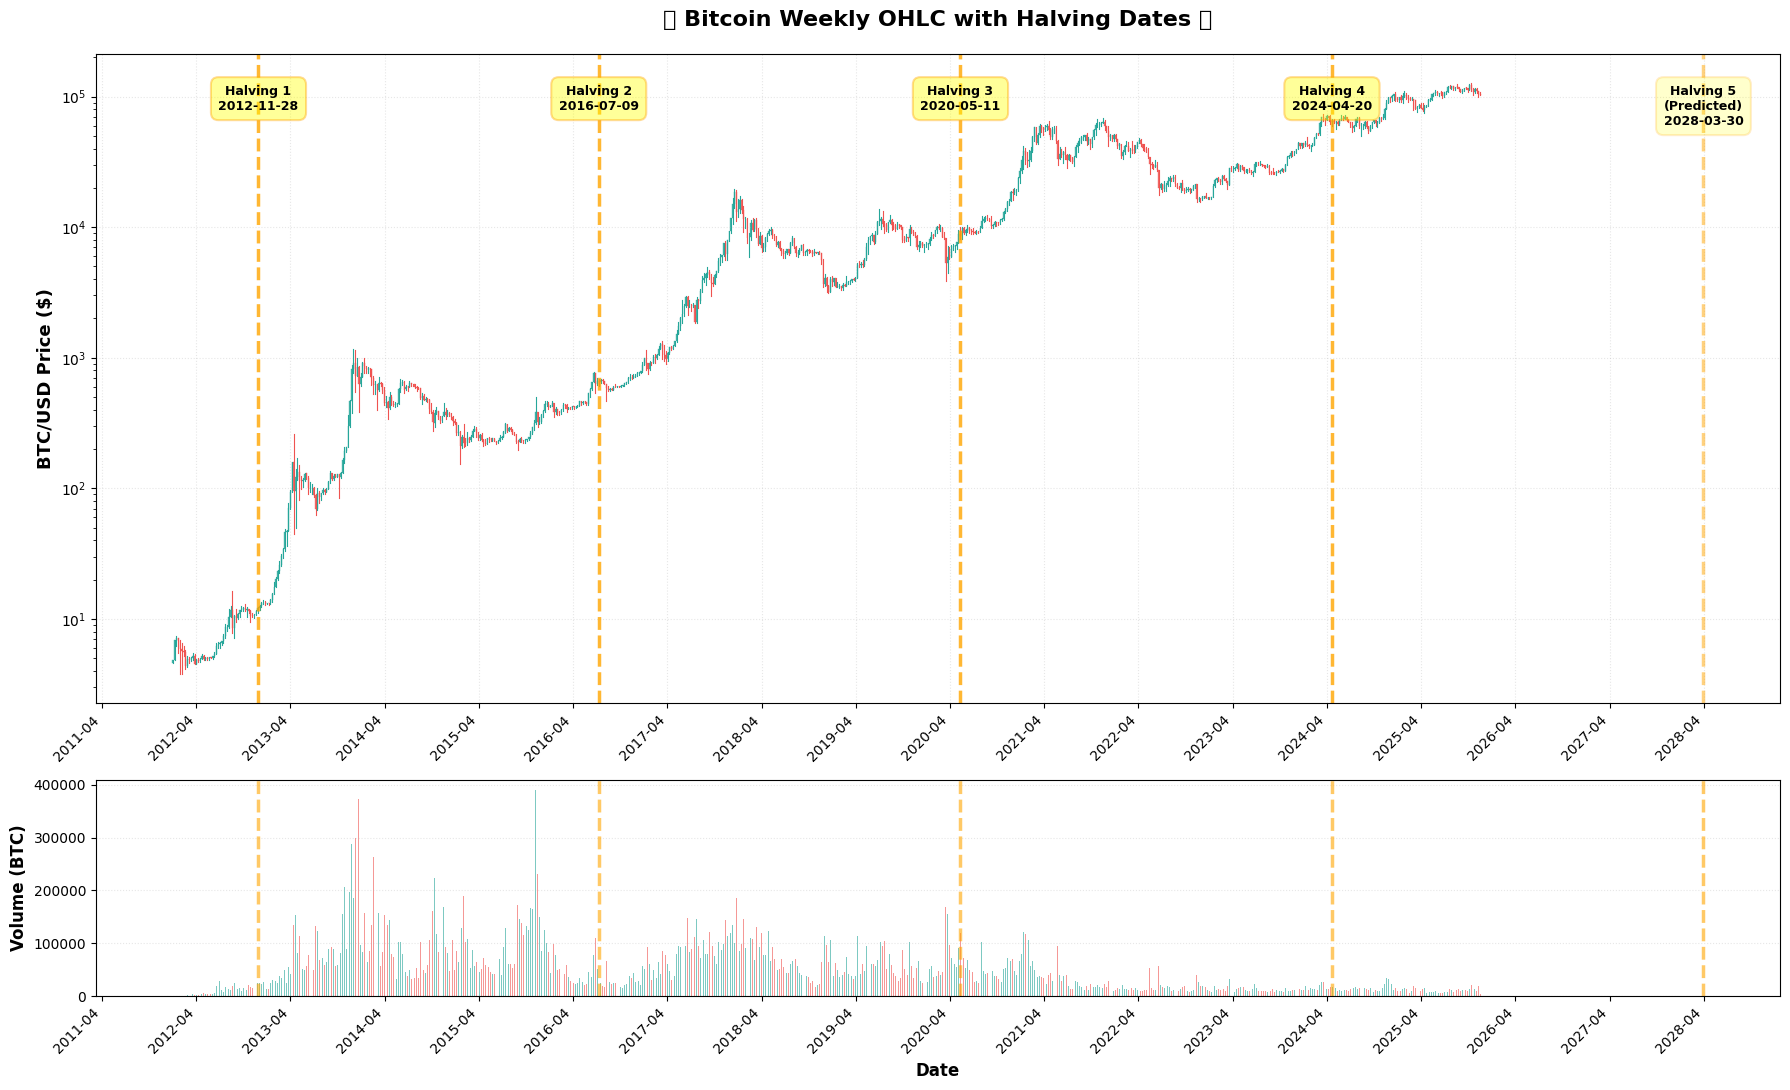


📍 РЕЗЮМЕ ХАЛФИНГОВ BITCOIN

✓ Халфинг 1: 28 November 2012 (Wednesday)}
  📅 Дней до следующего: 1319 дней (~3.61 лет)

✓ Халфинг 2: 09 July 2016 (Saturday)}
  📅 Дней до следующего: 1402 дней (~3.84 лет)

✓ Халфинг 3: 11 May 2020 (Monday)}
  📅 Дней до следующего: 1440 дней (~3.95 лет)

✓ Халфинг 4: 20 April 2024 (Saturday)}

⏰ ПРЕДСКАЗАННЫЙ ХАЛФИНГ 5: 30 March 2028 (Thursday)}
  📊 Дельта (промежуток): 1440 дней (~3.95 лет)
  ⌛ Дней до предсказанного халфинга: 868 дней


📊 ПОСЛЕДНИЕ 15 НЕДЕЛЬ:
---------------------------------------------------------------------------
  2025-08-10 | O:  114245 H:  119310 L:  112660 C:  119310 | Vol:   8128.66 BTC
  2025-08-17 | O:  119312 H:  124517 L:  116856 C:  117490 | Vol:  12210.10 BTC
  2025-08-24 | O:  117465 H:  117622 L:  110671 C:  113478 | Vol:  13207.83 BTC
  2025-08-31 | O:  113491 H:  113645 L:  107389 C:  108269 | Vol:  10323.70 BTC
  2025-09-07 | O:  108268 H:  113402 L:  107270 C:  111144 | Vol:  11838.76 BTC
  2025-09-14 | O:  111144 H

In [1]:
# @title скачивание данных
# Bitcoin OHLC analysis with halving dates visualization
# Скачивает данные с Bitstamp и строит недельный график с отметкой халфингов

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import gzip
import io
import requests
import os # Import the os module
import warnings # Import the warnings module

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning) # For pandas 'w' deprecation
warnings.filterwarnings("ignore", message="Glyph .* missing from font") # For matplotlib emoji warnings

# ============================================================================
# ШАГ 1: СКАЧИВАНИЕ И ЗАГРУЗКА ДАННЫХ
# ============================================================================

def create_sample_data():
    """
    Создает демонстрационные данные BTC/USD для примера
    """
    print("    📊 Генерация примера данных...")

    # Генерируем данные от 2012 года
    dates = pd.date_range(start='2012-01-01', end='2025-01-07', freq='1min')
    np.random.seed(42)

    # Симулируем цену BTC с реалистичным трендом
    price_trend = np.linspace(5, 102000, len(dates))
    noise = np.cumsum(np.random.randn(len(dates)) * 10)
    prices = price_trend + noise
    prices = np.maximum(prices, 1)  # Цена не может быть отрицательной

    data = {
        'timestamp': (dates.astype(np.int64) // 10**9).astype(int),
        'open': prices * (1 + np.random.randn(len(dates)) * 0.001),
        'high': prices * (1 + np.abs(np.random.randn(len(dates)) * 0.002)),
        'low': prices * (1 - np.abs(np.random.randn(len(dates)) * 0.002)),
        'close': prices,
        'volume': np.abs(np.random.randn(len(dates)) * 10 + 5)
    }

    return pd.DataFrame(data)


def download_bitstamp_data():
    """
    Скачивает исторические и свежие данные котировок BTC/USD с Bitstamp
    """
    print("📥 Получение данных Bitstamp...")

    # URL данных
    hist_url = 'https://raw.githubusercontent.com/ff137/bitstamp-btcusd-minute-data/main/data/historical/btcusd_bitstamp_1min_2012-2025.csv.gz'
    recent_url = 'https://raw.githubusercontent.com/ff137/bitstamp-btcusd-minute-data/main/data/updates/btcusd_bitstamp_1min_latest.csv'

    dfs = []

    try:
        # Пытаемся скачать исторические данные
        print("  ⏳ Загрузка исторических данных (2012-2025)...")
        try:
            response = requests.get(hist_url, timeout=60)
            response.raise_for_status()
            df_hist = pd.read_csv(io.BytesIO(response.content), compression='gzip')
            print(f"    ✓ Загружено {len(df_hist):,} записей")
            dfs.append(df_hist)
        except Exception as e_hist:
            print(f"    ⚠️  Не удалось загрузить исторические: {type(e_hist).__name__}")
            dfs.append(create_sample_data())

        # Пытаемся скачать свежие данные
        if len(dfs) > 0:
            print("  ⏳ Загрузка последних обновлений...")
            try:
                response = requests.get(recent_url, timeout=60)
                response.raise_for_status()
                df_recent = pd.read_csv(io.BytesIO(response.content))
                print(f"    ✓ Загружено {len(df_recent):,} записей")
                dfs.append(df_recent)
            except Exception as e_recent:
                print(f"    ⚠️  Обновления недоступны: {type(e_recent).__name__}")

        # Объединяем данные
        df = pd.concat(dfs, ignore_index=True)
        df = df.drop_duplicates(subset=['timestamp'], keep='last')
        df = df.sort_values('timestamp').reset_index(drop=True)

        print(f"\n✓ Всего загружено {len(df):,} свечей")
        date_min = pd.to_datetime(df['timestamp'], unit='s').min().date()
        date_max = pd.to_datetime(df['timestamp'], unit='s').max().date()
        print(f"  Диапазон: {date_min} - {date_max}")

        return df

    except Exception as e:
        print(f"❌ Критическая ошибка: {e}")
        print("   Использую демонстрационные данные...")
        return create_sample_data()


def convert_to_ohlc(df, timeframe='1W'): # Changed '1w' to '1W'
    """
    Преобразует минутные данные в OHLC с указанным таймфреймом
    """
    print(f"\n📊 Преобразование данных в {timeframe} OHLC...")

    # Конвертируем timestamp в datetime
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('datetime')

    # Группируем по таймфрейму
    ohlc_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }

    df_ohlc = df.resample(timeframe).agg(ohlc_dict)
    df_ohlc = df_ohlc.dropna()
    df_ohlc = df_ohlc.reset_index()

    print(f"✓ Преобразовано в {len(df_ohlc)} свечей {timeframe}")

    return df_ohlc


# ============================================================================
# ШАГ 2: РАБОТА С ДАТАМИ ХАЛФИНГА
# ============================================================================

def get_bitcoin_halving_dates():
    """
    Возвращает известные даты халфингов Bitcoin
    """
    halvings = [
        datetime(2012, 11, 28),   # Халфинг 1: блок 210,000
        datetime(2016, 7, 9),     # Халфинг 2: блок 420,000
        datetime(2020, 5, 11),    # Халфинг 3: блок 630,000
        datetime(2024, 4, 20),    # Халфинг 4: блок 840,000
    ]
    return halvings


def predict_next_halving(halving_dates):
    """
    Предсказывает следующий халфинг на основе дельты между последними двумя
    """
    if len(halving_dates) < 2:
        return None

    last_halving = halving_dates[-1]
    prev_halving = halving_dates[-2]
    delta = last_halving - prev_halving
    predicted_next = last_halving + delta

    return predicted_next


# ============================================================================
# ШАГ 3: ПОСТРОЕНИЕ ГРАФИКА
# ============================================================================

def plot_weekly_ohlc_with_halvings(df_ohlc, output_file='bitcoin_weekly_ohlc.png'):
    """
    Строит недельный график OHLC с отметкой дат халфинга
    """

    print("\n🎨 Построение графика...")

    # Создаем директорию, если она не существует
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Получаем даты халфинга
    halving_dates = get_bitcoin_halving_dates()
    next_halving = predict_next_halving(halving_dates)

    if next_halving:
        halving_dates = halving_dates + [next_halving]

    # Создаем фигуру
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 11),
                                     gridspec_kw={'height_ratios': [3, 1]})
    fig.patch.set_facecolor('white')

    # ========== Верхний график: Цена и Халфинги ==========

    # Построение свечей OHLC
    width = 3  # ширина свечи в днях

    colors_up = '#26a69a'    # зелёный для роста
    colors_down = '#ef5350'  # красный для падения

    print("  Рисую свечи...")
    for idx, row in df_ohlc.iterrows():
        date = mdates.date2num(row['datetime'])
        open_price = row['open']
        close_price = row['close']
        high_price = row['high']
        low_price = row['low']

        # Выбираем цвет
        color = colors_up if close_price >= open_price else colors_down

        # Хай-лоу линия (тень)
        ax1.plot([date, date], [low_price, high_price], color=color, linewidth=0.8)

        # Опен-клоуз прямоугольник (тело свечи)
        height = abs(close_price - open_price)
        bottom = min(open_price, close_price)

        rect = plt.Rectangle((date - width/2, bottom), width, height,
                            facecolor=color, edgecolor=color, linewidth=0.3, alpha=0.8)
        ax1.add_patch(rect)

    print("  Добавляю разметку халфингов...")
    # Разметка халфингов
    y_min, y_max = ax1.get_ylim()

    for i, halving_date in enumerate(halving_dates):
        halving_num = i + 1
        is_predicted = (i == len(halving_dates) - 1) and (next_halving is not None)

        x_pos = mdates.date2num(halving_date)

        if is_predicted:
            # Следующий халфинг - более светлая линия
            ax1.axvline(x_pos, color='orange', linestyle='--', linewidth=2.5,
                       alpha=0.5, label='Predicted halving' if i == 0 else '')
            label_text = f'Halving {halving_num}\n(Predicted)\n{halving_date.strftime("%Y-%m-%d")}'
            box_alpha = 0.2
        else:
            # Прошлые халфинги - более яркая линия
            ax1.axvline(x_pos, color='orange', linestyle='--', linewidth=2.5,
                       alpha=0.8, label='Bitcoin halving' if i == 0 else '')
            label_text = f'Halving {halving_num}\n{halving_date.strftime("%Y-%m-%d")}'
            box_alpha = 0.4

        # Добавляем текстовую подпись
        y_pos = ax1.get_ylim()[1] * 0.93
        ax1.text(x_pos, y_pos, label_text,
                rotation=0, verticalalignment='top', horizontalalignment='center',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.6',
                         facecolor='yellow', alpha=box_alpha, edgecolor='orange', linewidth=1.5))

    # Форматирование верхнего графика
    ax1.set_ylabel('BTC/USD Price ($)', fontsize=13, fontweight='bold')
    ax1.set_title('📈 Bitcoin Weekly OHLC with Halving Dates 🪙',
                 fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle=':')
    ax1.set_yscale('log')  # Логарифмическая шкала для лучшей видимости
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # ========== Нижний график: Объём ==========

    print("  Рисую объёмы...")
    colors_volume = [colors_up if df_ohlc.iloc[i]['close'] >= df_ohlc.iloc[i]['open']
                     else colors_down for i in range(len(df_ohlc))]

    dates_num = [mdates.date2num(d) for d in df_ohlc['datetime']]

    ax2.bar(dates_num, df_ohlc['volume'], width=width, color=colors_volume, alpha=0.6)

    # Разметка халфингов на графике объёмов
    for i, halving_date in enumerate(halving_dates):
        ax2.axvline(mdates.date2num(halving_date),
                   color='orange', linestyle='--', linewidth=2.5,
                   alpha=0.6)

    # Форматирование нижнего графика
    ax2.set_ylabel('Volume (BTC)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle=':', axis='y')
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()

    # Сохраняем график
    print(f"  Сохраняю график...")
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ График сохранён: {output_file}")

    plt.show()

    return halving_dates


def print_halving_summary(halving_dates):
    """Выводит сводку по данным"""
    actual_halvings = get_bitcoin_halving_dates()

    print("\n" + "="*75)
    print("📍 РЕЗЮМЕ ХАЛФИНГОВ BITCOIN")
    print("="*75)

    for i, date in enumerate(actual_halvings, 1):
        print(f"\n✓ Халфинг {i}: {date.strftime('%d %B %Y (%A)}')}")
        if i < len(actual_halvings):
            days_until_next = (actual_halvings[i] - date).days
            print(f"  📅 Дней до следующего: {days_until_next} дней (~{days_until_next/365:.2f} лет)")

    if len(halving_dates) > len(actual_halvings):
        next_halving = halving_dates[-1]
        print(f"\n⏰ ПРЕДСКАЗАННЫЙ ХАЛФИНГ {len(actual_halvings) + 1}: {next_halving.strftime('%d %B %Y (%A)}')}")

        # Дельта между последними двумя
        delta = actual_halvings[-1] - actual_halvings[-2]
        print(f"  📊 Дельта (промежуток): {delta.days} дней (~{delta.days/365:.2f} лет)")

        # Дни до предсказанного халфинга
        days_to_pred = (next_halving - datetime.now()).days
        if days_to_pred > 0:
            print(f"  ⌛ Дней до предсказанного халфинга: {days_to_pred} дней")
        else:
            print(f"  ✓ Предсказанный халфинг в прошлом: {abs(days_to_pred)} дней назад")

    print("\n" + "="*75)


def print_data_summary(df_weekly):
    """Выводит сводку по данным"""
    print("\n" + "="*75)
    print("📊 СТАТИСТИКА ДАННЫХ")
    print("="*75)

    print(f"\nВсего свечей (недельных): {len(df_weekly):,}")
    print(f"Первая свеча: {df_weekly['datetime'].min().date()}")
    print(f"Последняя свеча: {df_weekly['datetime'].max().date()}")

    print(f"\nПока цены (в USD):")
    print(f"  Минимум: ${df_weekly['low'].min():,.2f}")
    print(f"  Максимум: ${df_weekly['high'].max():,.2f}")
    print(f"  Текущая: ${df_weekly['close'].iloc[-1]:,.2f}")

    print(f"\nОбъем торговли (недельный, в BTC):")
    print(f"  Средний: {df_weekly['volume'].mean():,.2f}")
    print(f"  Минимум: {df_weekly['volume'].min():,.2f}")
    print(f"  Максимум: {df_weekly['volume'].max():,.2f}")

    print("\n" + "="*75)


def get_weekly_ohlc_data():
    """
    Загружает и обрабатывает данные, возвращая недельный OHLC DataFrame.
    """
    df_raw = download_bitstamp_data()
    df_weekly = convert_to_ohlc(df_raw, timeframe='1W')
    return df_weekly


# ============================================================================
# ГЛАВНАЯ ФУНКЦИЯ
# ============================================================================

def main():
    """Главная функция"""

    print("\n" + "="*75)
    print("🚀 АНАЛИЗ BITCOIN HALVING С OHLC ДАННЫМИ")
    print("="*75)

    # Шаг 1: Скачиваем данные и преобразуем в недельный OHLC
    df_weekly = get_weekly_ohlc_data()

    # Шаг 3: Выводим статистику
    print_data_summary(df_weekly)

    # Шаг 4: Строим график с халфингами
    halving_dates = plot_weekly_ohlc_with_halvings(
        df_weekly,
        output_file='/mnt/user-data/outputs/bitcoin_weekly_ohlc.png'
    )

    # Шаг 5: Выводим резюме халфингов
    print_halving_summary(halving_dates)

    # Выводим последние данные
    print("\n📊 ПОСЛЕДНИЕ 15 НЕДЕЛЬ:")
    print("-" * 75)
    for idx, row in df_weekly.tail(15).iterrows():
        print(f"  {row['datetime'].date()} | O:{row['open']:8.0f} H:{row['high']:8.0f} "
              f"L:{row['low']:8.0f} C:{row['close']:8.0f} | Vol:{row['volume']:10.2f} BTC")

    print("\n✅ АНАЛИЗ ЗАВЕРШЁН!")
    print(f"📸 Результат сохранён в: /mnt/user-data/outputs/bitcoin_weekly_ohlc.png")

    return df_weekly

if __name__ == '__main__':
    df_weekly = main()

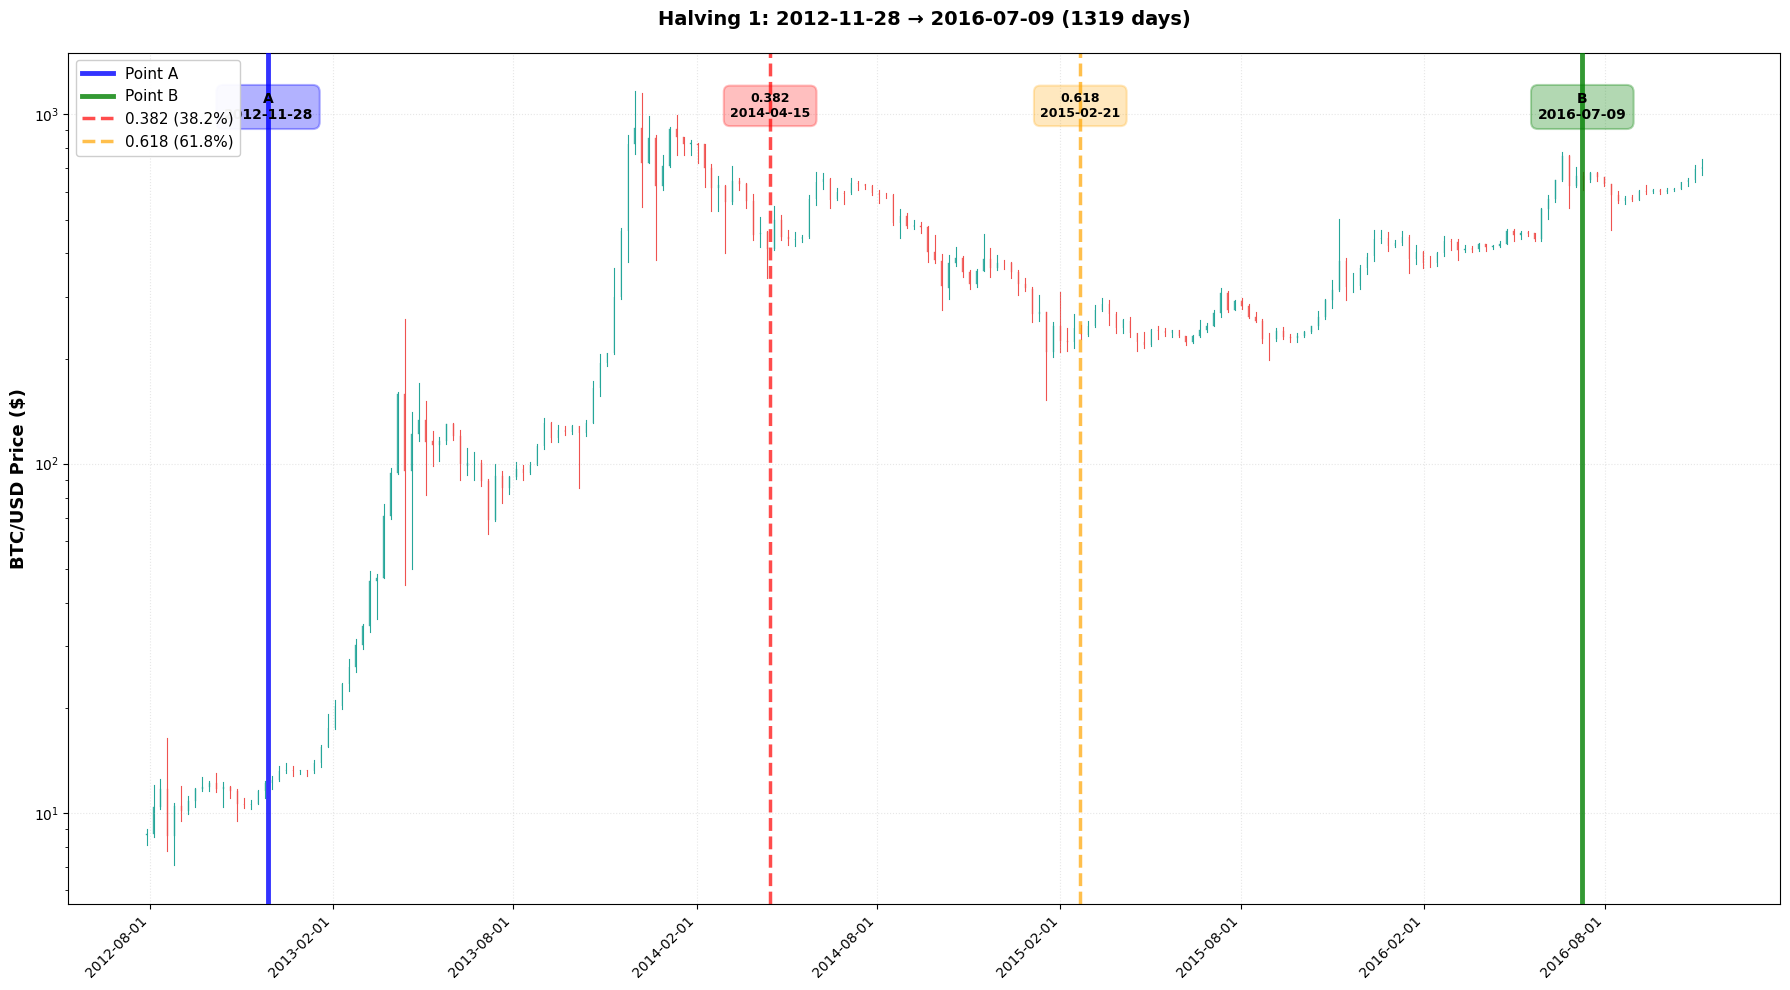

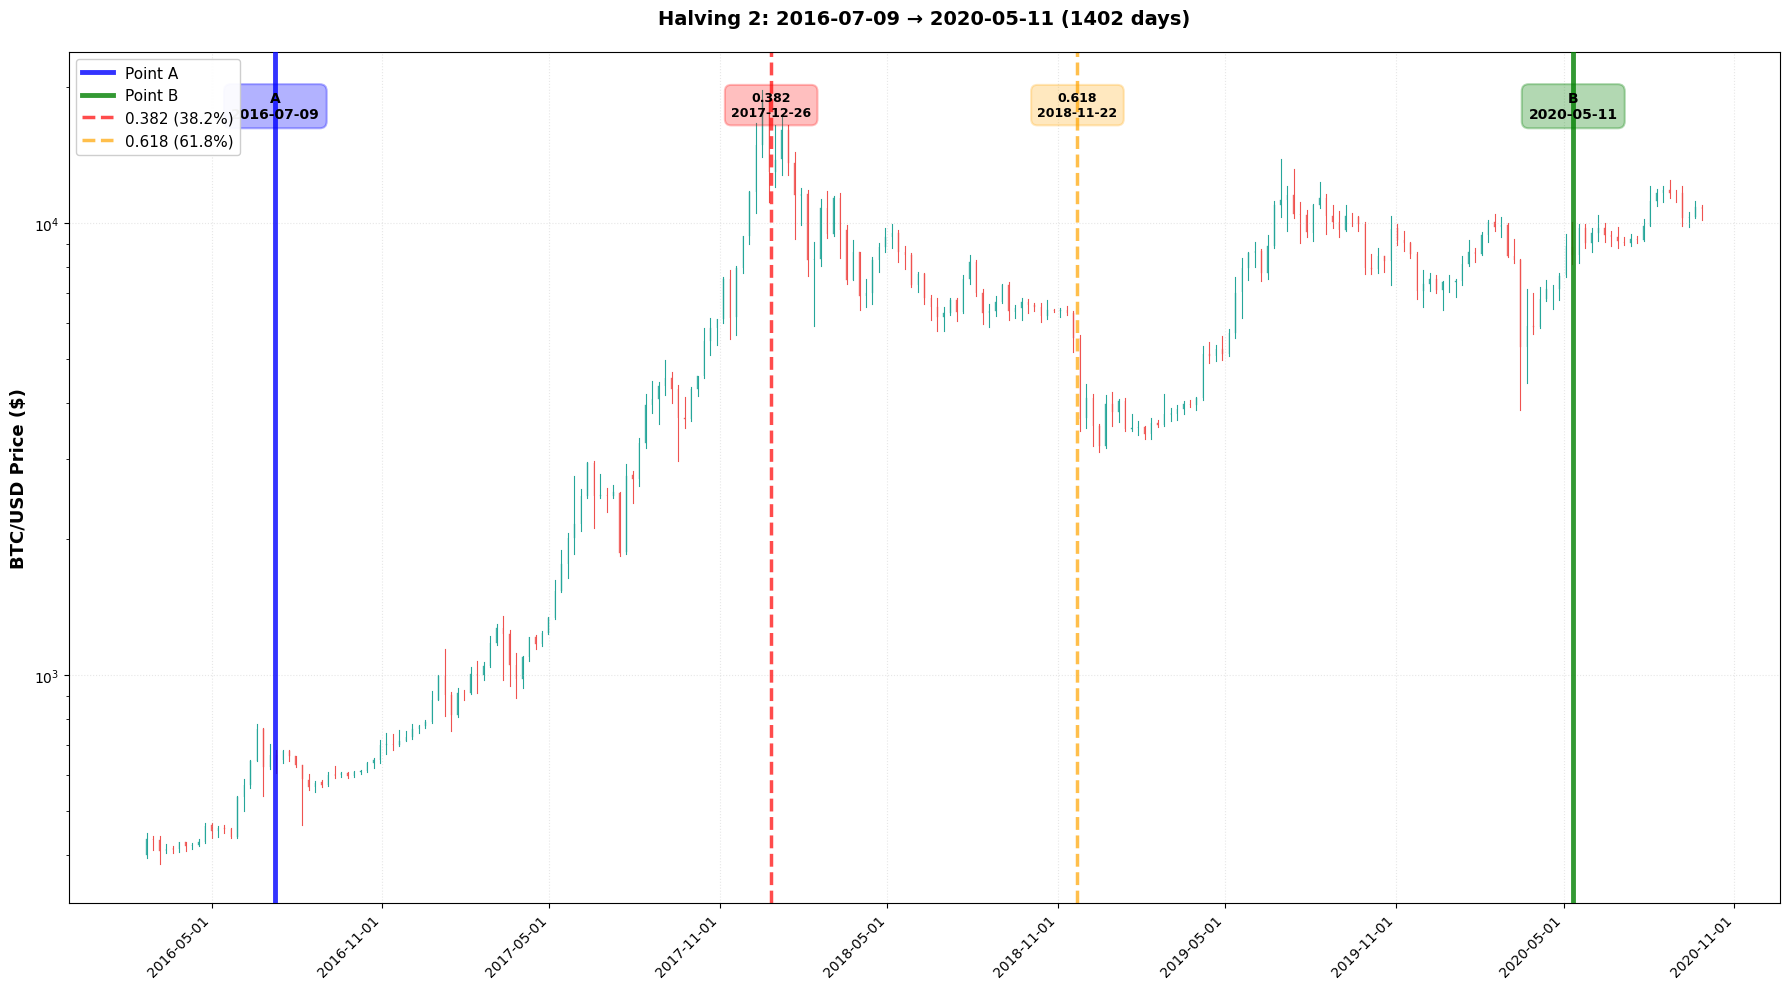

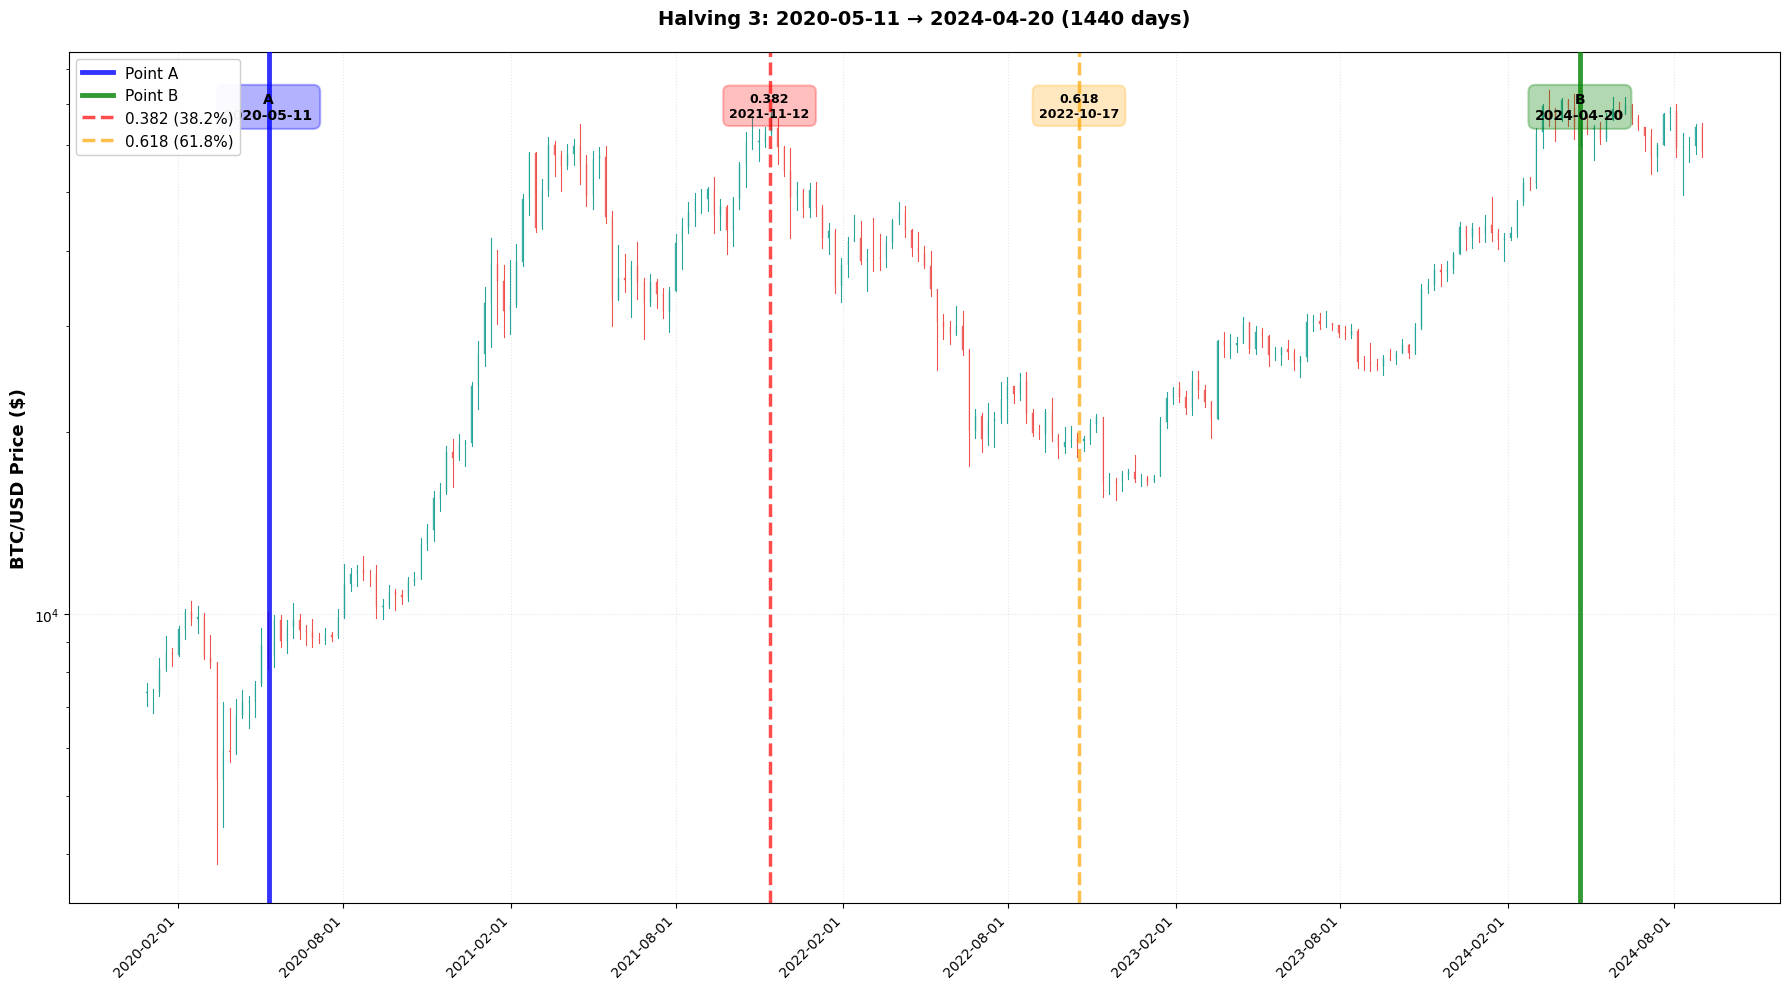

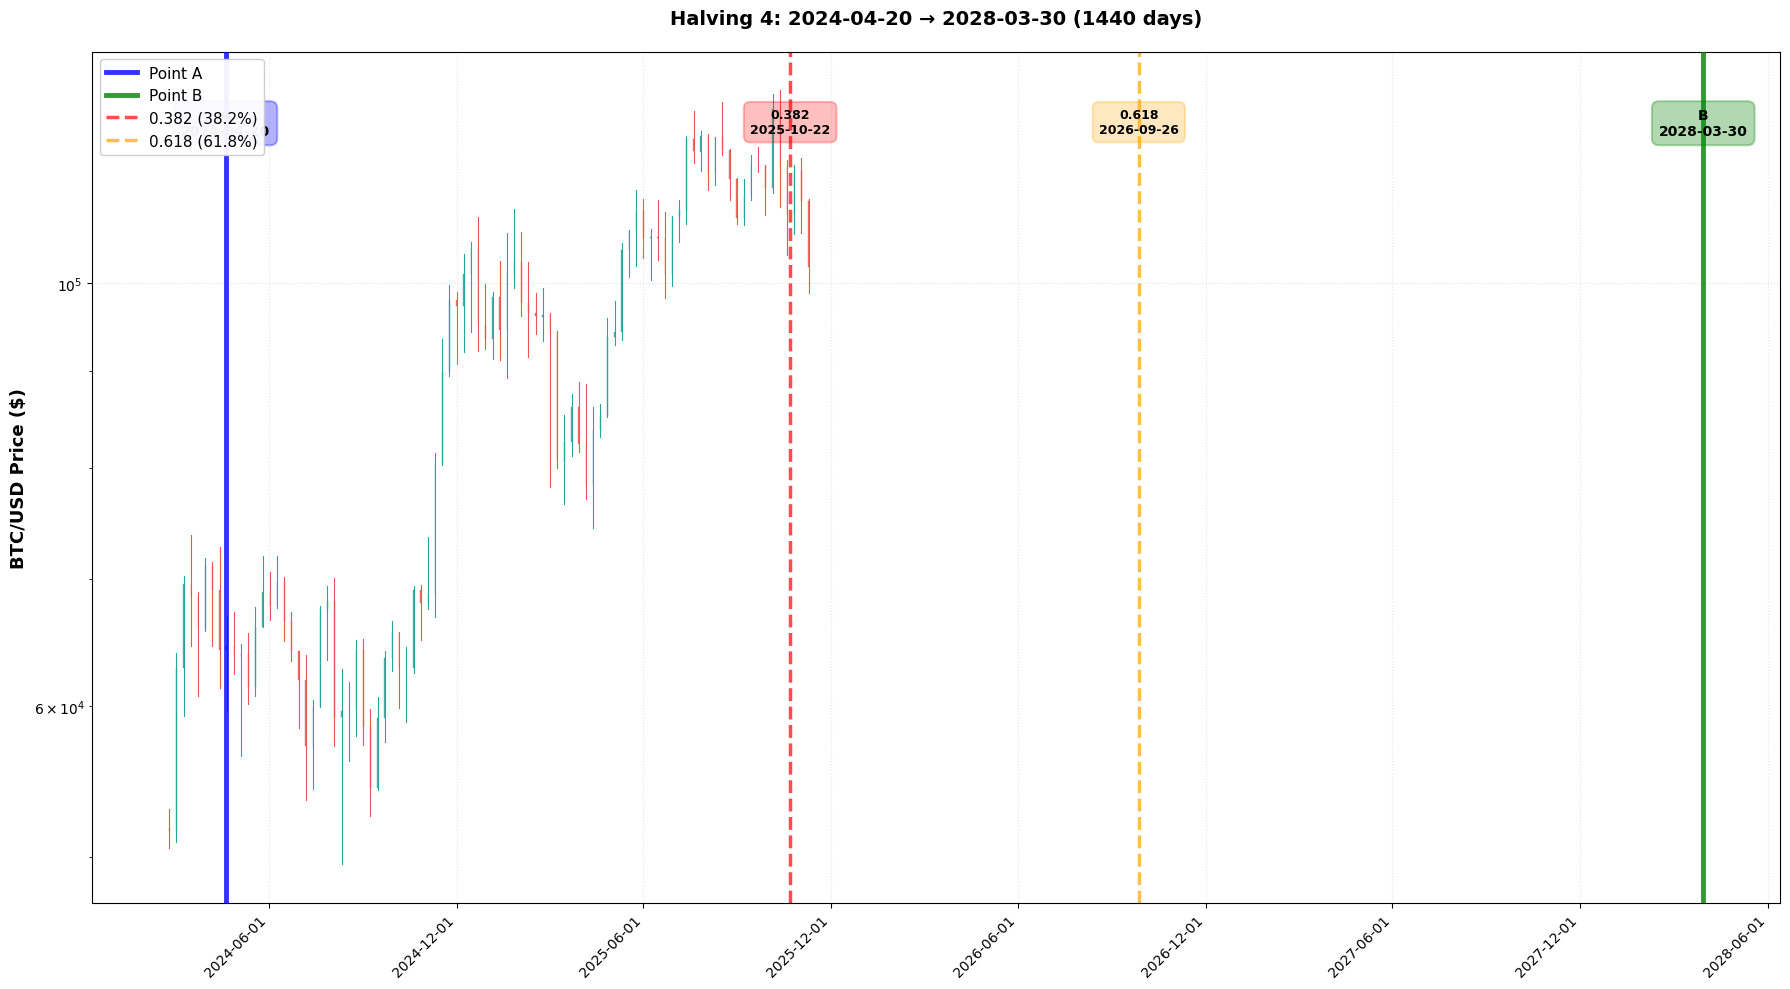

In [ ]:
# @title добавляем точки 38,2 61,8
def plot_halving_segments(df_weekly):
    halvings = [
        datetime(2012, 11, 28),
        datetime(2016, 7, 9),
        datetime(2020, 5, 11),
        datetime(2024, 4, 20),
    ]

    next_halving = halvings[-1] + (halvings[-1] - halvings[-2])
    halvings.append(next_halving)

    for i in range(len(halvings)-1):
        date_a = halvings[i]
        date_b = halvings[i+1]
        delta_days = (date_b - date_a).days

        point_382 = date_a + timedelta(days=delta_days * 0.382)
        point_618 = date_a + timedelta(days=delta_days * 0.618)

        mask = (df_weekly['datetime'] >= date_a) & (df_weekly['datetime'] <= date_b)
        segment = df_weekly[mask].copy()

        if len(segment) == 0:
            continue

        start_idx = segment.index[0]
        end_idx = segment.index[-1]
        n_bars = len(segment)
        margin_bars = int(n_bars * 0.10)

        new_start_idx = max(0, start_idx - margin_bars)
        new_end_idx = min(len(df_weekly) - 1, end_idx + margin_bars)
        df_segment = df_weekly.iloc[new_start_idx:new_end_idx+1].copy()

        fig, ax = plt.subplots(figsize=(18, 10))
        fig.patch.set_facecolor('white')

        width = 0.6
        colors_up = '#26a69a'
        colors_down = '#ef5350'

        for idx, row in df_segment.iterrows():
            date = mdates.date2num(row['datetime'])
            o, h, l, c = row['open'], row['high'], row['low'], row['close']
            color = colors_up if c >= o else colors_down

            ax.plot([date, date], [l, h], color=color, linewidth=0.8, zorder=1)

            height = abs(c - o)
            bottom = min(o, c)
            rect = plt.Rectangle((date - width/2, bottom), width, height,
                                facecolor=color, edgecolor=color, linewidth=0.3, alpha=0.8, zorder=2)
            ax.add_patch(rect)

        x_a = mdates.date2num(date_a)
        x_b = mdates.date2num(date_b)
        x_382 = mdates.date2num(point_382)
        x_618 = mdates.date2num(point_618)

        ax.axvline(x_a, color='blue', linestyle='-', linewidth=3.5, alpha=0.8, label='Point A', zorder=3)
        ax.axvline(x_b, color='green', linestyle='-', linewidth=3.5, alpha=0.8, label='Point B', zorder=3)
        ax.axvline(x_382, color='red', linestyle='--', linewidth=2.5, alpha=0.7, label='0.382 (38.2%)', zorder=2)
        ax.axvline(x_618, color='orange', linestyle='--', linewidth=2.5, alpha=0.7, label='0.618 (61.8%)', zorder=2)

        y_max = ax.get_ylim()[1]
        y_pos = y_max * 0.95

        ax.text(x_a, y_pos, f'A\n{date_a.strftime("%Y-%m-%d")}', ha='center', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='blue', alpha=0.3, edgecolor='blue', linewidth=1.5))
        ax.text(x_b, y_pos, f'B\n{date_b.strftime("%Y-%m-%d")}', ha='center', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='green', alpha=0.3, edgecolor='green', linewidth=1.5))
        ax.text(x_382, y_pos, f'0.382\n{point_382.strftime("%Y-%m-%d")}', ha='center', va='top', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.25, edgecolor='red', linewidth=1.5))
        ax.text(x_618, y_pos, f'0.618\n{point_618.strftime("%Y-%m-%d")}', ha='center', va='top', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='orange', alpha=0.25, edgecolor='orange', linewidth=1.5))

        ax.set_ylabel('BTC/USD Price ($)', fontsize=13, fontweight='bold')
        ax.set_title(f'Halving {i+1}: {date_a.strftime("%Y-%m-%d")} → {date_b.strftime("%Y-%m-%d")} ({delta_days} days)',
                    fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3, linestyle=':')
        ax.set_yscale('log')
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.legend(loc='upper left', fontsize=11, framealpha=0.95)

        plt.tight_layout()
        plt.show()

plot_halving_segments(df_weekly)


HALVING 1: 2012-11-28 → 2016-07-09
Points: A=2014-04-15 (38.2%) | B=2015-02-21 (61.8%)
Price at start: $8.72
Price at A: $497.04
Price at B: $234.15
Duration: 3.61 years

Strategy                                      Return       MaxDD        Sharpe     Calmar    
-----------------------------------------------------------------------------------------
1. Hold                                          7984.52%     -77.05%     1.49     3.08
2. Hold→USDT A-B→Buy B                          17061.35%     -56.43%     1.71     5.59
3. Hold→Short A-B→Buy B                         26138.17%     -62.56%     1.79     5.88
4. Buy 1.382x→Short 1.382x A-B→Buy B            36046.14%     -62.73%     1.83     6.55

HALVING 2: 2016-07-09 → 2020-05-11
Points: A=2017-12-26 (38.2%) | B=2018-11-22 (61.8%)
Price at start: $434.46
Price at A: $13808.19
Price at B: $3694.66
Duration: 3.84 years

Strategy                                      Return       MaxDD        Sharpe     Calmar    
---------------------

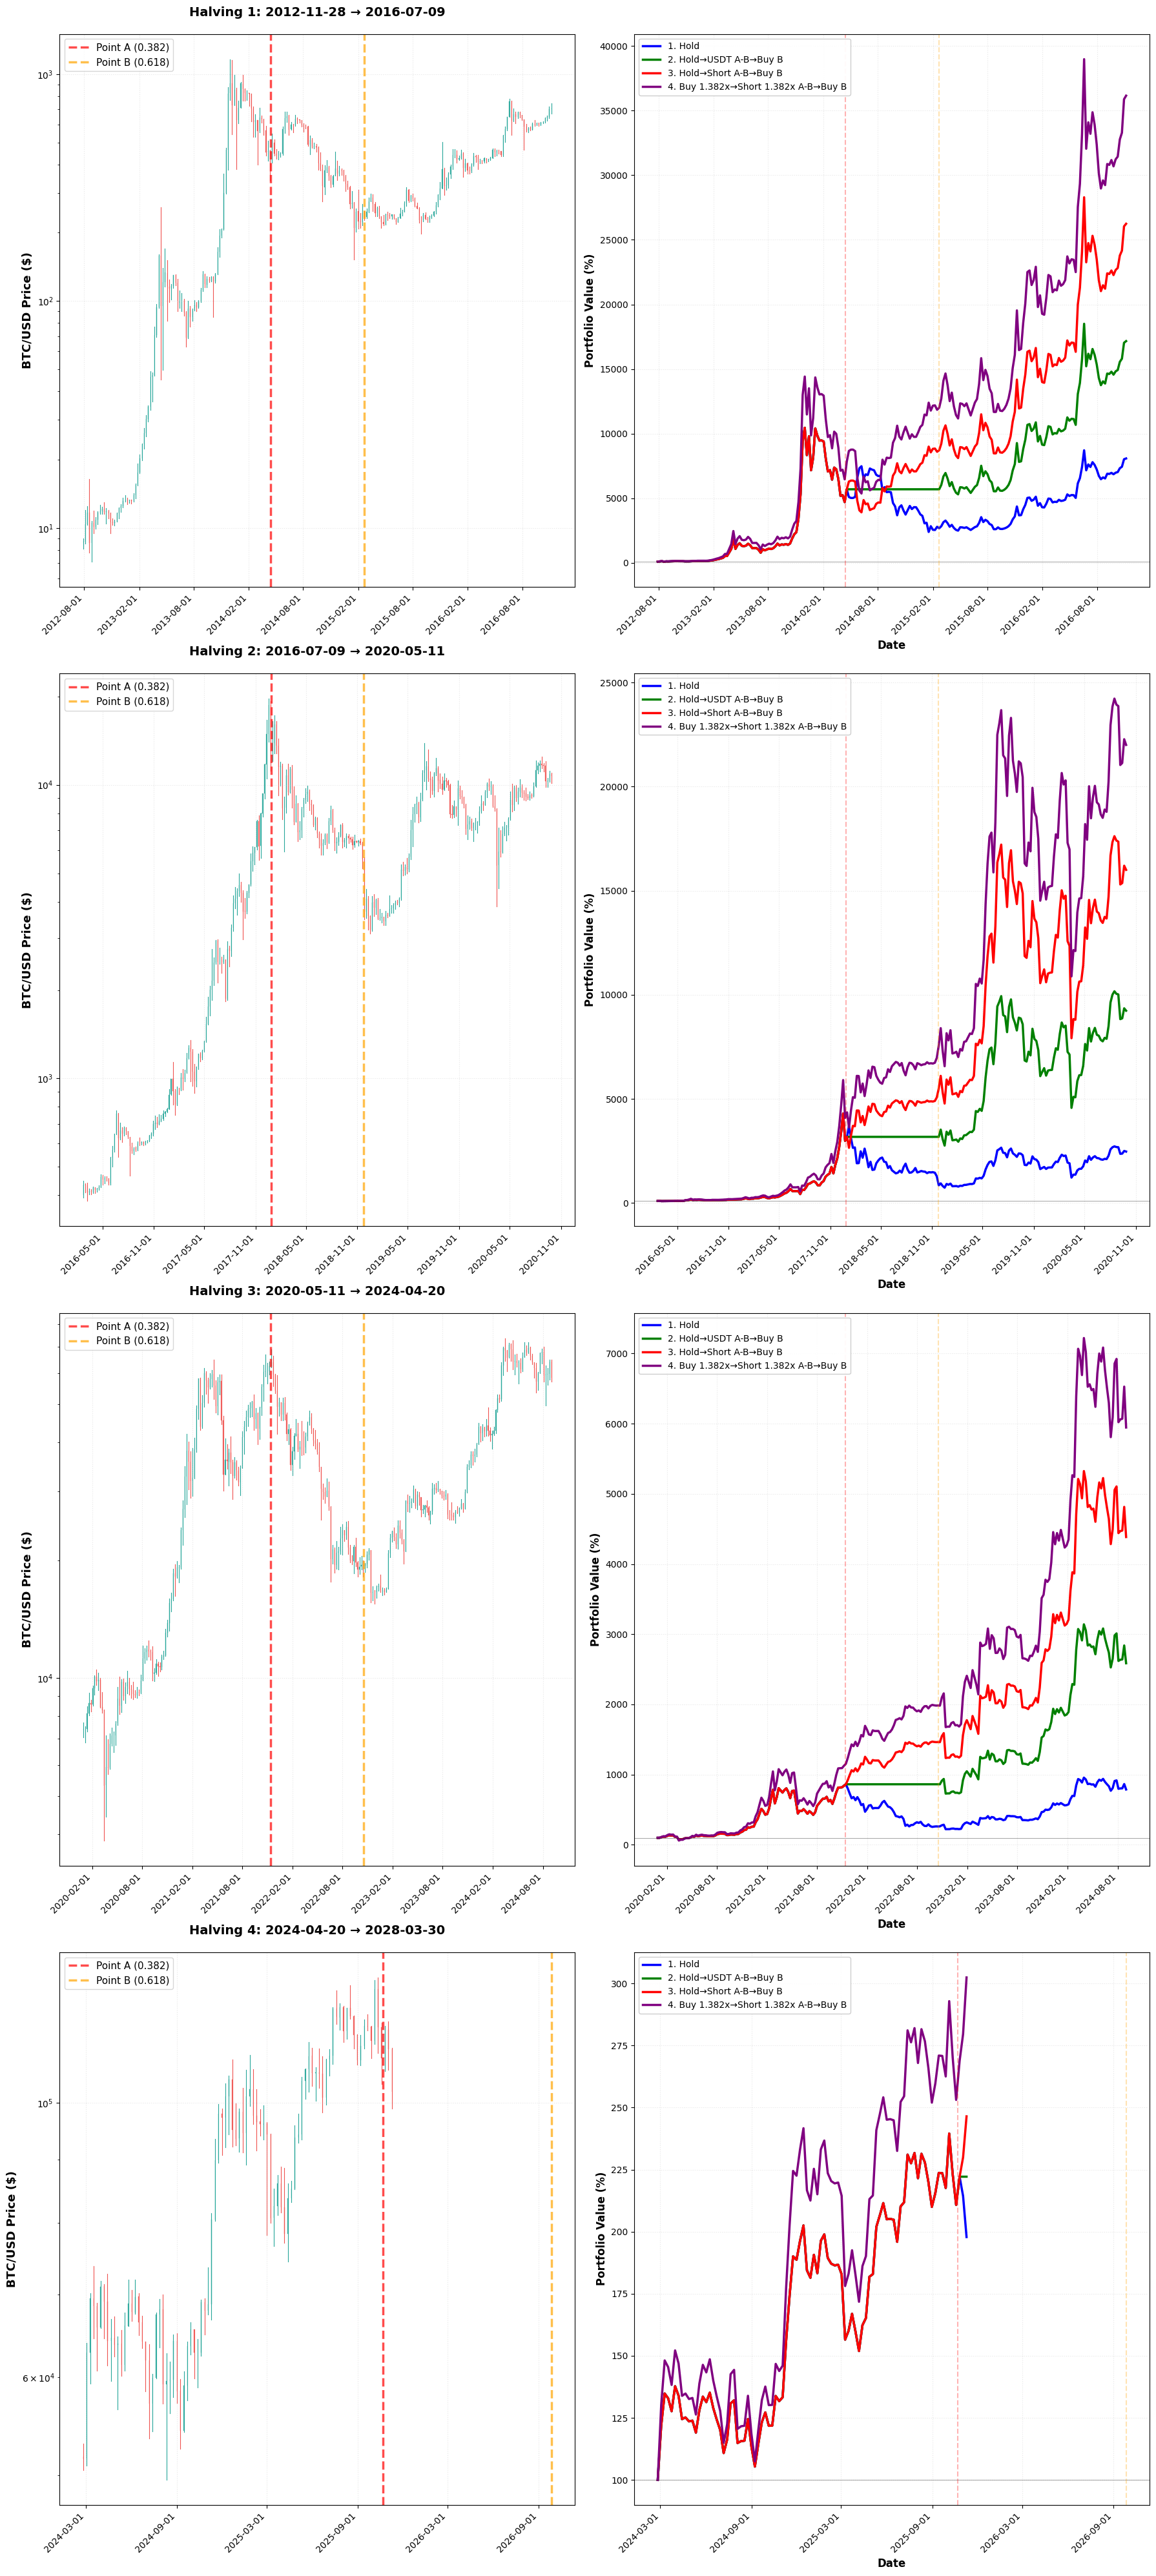

In [ ]:
# @title Простые стратегии
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

class Portfolio:
    """Класс для отслеживания портфеля"""
    def __init__(self, initial_price):
        self.initial_price = initial_price
        self.btc_amount = 1.0  # Начинаем с 1 BTC
        self.usd_amount = 0.0
        self.debt = 0.0  # Долг в USD (для плеча)
        self.short_amount = 0.0  # Количество BTC в short позиции
        self.short_entry_price = 0.0  # Цена входа в short
        self.history = []

    def get_value(self, current_price):
        """Получить текущую стоимость портфеля в USD (за вычетом долга)"""
        btc_value = self.btc_amount * current_price
        usd_value = self.usd_amount

        # Если есть short позиция, добавляем/вычитаем PnL
        if self.short_amount > 0:
            short_pnl = self.short_amount * (self.short_entry_price - current_price)
            usd_value += short_pnl

        # Вычитаем долг
        total_value = btc_value + usd_value - self.debt

        return total_value

    def get_equity(self, current_price):
        """Получить эквити относительно начальной цены"""
        return self.get_value(current_price) / self.initial_price

    def buy_btc(self, price, leverage=1.0):
        """Купить BTC (с плечом если нужно)"""
        if self.usd_amount > 0:
            btc_to_buy = (self.usd_amount / price) * leverage
            self.btc_amount += btc_to_buy

            # Если плечо > 1, создаем долг
            if leverage > 1.0:
                self.debt += self.usd_amount * (leverage - 1.0)

            self.usd_amount = 0

    def buy_btc_with_leverage(self, price, leverage):
        """Купить BTC с плечом от начального капитала"""
        # Начальный капитал в USD
        initial_capital = self.initial_price

        # Покупаем BTC с плечом
        self.btc_amount = leverage

        # Долг = (стоимость позиции) - (начальный капитал)
        position_value = leverage * price
        self.debt = position_value - initial_capital

    def sell_btc_to_usdt(self, price):
        """Продать весь BTC в USDT"""
        self.usd_amount = self.btc_amount * price
        self.btc_amount = 0

        # Если есть долг, возвращаем его
        if self.debt > 0:
            self.usd_amount -= self.debt
            self.debt = 0

    def open_short(self, price, amount):
        """Открыть short позицию"""
        self.short_amount = amount
        self.short_entry_price = price

    def close_short(self, price):
        """Закрыть short позицию и получить PnL в USD"""
        if self.short_amount > 0:
            pnl = self.short_amount * (self.short_entry_price - price)
            self.usd_amount += pnl
            self.short_amount = 0
            self.short_entry_price = 0

    def hold(self, price):
        """Просто держим текущую позицию"""
        pass

    def record(self, price):
        """Записать текущее состояние"""
        self.history.append(self.get_equity(price))

    def get_history_array(self):
        """Получить историю как numpy array"""
        return np.array(self.history)


def simulate_strategy_1_hold(prices, price_start):
    """Стратегия 1: Просто Hold"""
    portfolio = Portfolio(price_start)

    for price in prices:
        portfolio.hold(price)
        portfolio.record(price)

    return portfolio.get_history_array()


def simulate_strategy_2_usdt_ab(prices, price_start, idx_a, idx_b, price_at_a, price_at_b):
    """Стратегия 2: Hold → USDT (A-B) → Buy B"""
    portfolio = Portfolio(price_start)

    for j, price in enumerate(prices):
        if j < idx_a:
            # До точки A: держим BTC
            portfolio.hold(price)
        elif j == idx_a:
            # В точке A: продаем BTC в USDT
            portfolio.sell_btc_to_usdt(price_at_a)
        elif j < idx_b:
            # От A до B: держим USDT
            portfolio.hold(price)
        elif j == idx_b:
            # В точке B: покупаем BTC на все USDT
            portfolio.buy_btc(price_at_b)
        else:
            # После B: держим BTC
            portfolio.hold(price)

        portfolio.record(price)

    return portfolio.get_history_array()


def simulate_strategy_3_short_ab(prices, price_start, idx_a, idx_b, price_at_a, price_at_b):
    """Стратегия 3: Hold → Short (A-B) → Buy B

    В точке A:
    1. ПРОДАЕМ весь BTC → получаем USD
    2. Открываем SHORT позицию на 1 BTC (зарабатываем на падении)

    От A до B:
    - Держим USD (фиксированная сумма)
    - Short позиция зарабатывает на падении цены

    В точке B:
    - Закрываем short, получаем PnL
    - Покупаем BTC на все USD (начальные USD + PnL от short)
    """
    portfolio = Portfolio(price_start)

    for j, price in enumerate(prices):
        if j < idx_a:
            # До точки A: держим BTC
            portfolio.hold(price)
        elif j == idx_a:
            # В точке A:
            # 1. Продаем BTC в USD
            btc_amount_before_sell = portfolio.btc_amount
            portfolio.sell_btc_to_usdt(price_at_a)
            # 2. Открываем short на то количество BTC, которое продали
            portfolio.open_short(price_at_a, btc_amount_before_sell)
        elif j < idx_b:
            # От A до B: держим USD + short зарабатывает на падении
            portfolio.hold(price)
        elif j == idx_b:
            # В точке B:
            # 1. Закрываем short, получаем PnL в USD
            portfolio.close_short(price_at_b)
            # 2. Покупаем BTC на все доступные USD
            portfolio.buy_btc(price_at_b)
        else:
            # После B: держим BTC
            portfolio.hold(price)

        portfolio.record(price)

    return portfolio.get_history_array()


def simulate_strategy_4_leveraged_short_ab(prices, price_start, idx_a, idx_b, price_at_a, price_at_b, leverage=1.382):
    """Стратегия 4: Buy с плечом → Short с плечом (A-B) → Buy B

    От старта:
    - Начальный капитал = price_start (100%)
    - Покупаем BTC с плечом 1.382x
    - Баланс = стоимость позиции - долг = price_start (100%)

    В точке A:
    1. ПРОДАЕМ весь BTC (1.382) → получаем USD, возвращаем долг
    2. Открываем SHORT позицию на 1.382 BTC

    От A до B:
    - Держим USD
    - Short позиция зарабатывает на падении (с плечом)

    В точке B:
    - Закрываем short, получаем PnL
    - Покупаем BTC на все USD
    """
    portfolio = Portfolio(price_start)

    # Покупаем с плечом: позиция = 1.382 BTC, долг создается автоматически
    portfolio.buy_btc_with_leverage(price_start, leverage)

    for j, price in enumerate(prices):
        if j < idx_a:
            # До точки A: держим BTC с плечом
            # Баланс = 1.382 * price - долг
            portfolio.hold(price)
        elif j == idx_a:
            # В точке A:
            # 1. Продаем BTC в USD (долг автоматически вычитается)
            btc_amount_before_sell = portfolio.btc_amount
            portfolio.sell_btc_to_usdt(price_at_a)
            # 2. Открываем short на то количество BTC, которое продали
            portfolio.open_short(price_at_a, btc_amount_before_sell)
        elif j < idx_b:
            # От A до B: держим USD + short зарабатывает на падении
            portfolio.hold(price)
        elif j == idx_b:
            # В точке B:
            # 1. Закрываем short, получаем PnL в USD
            portfolio.close_short(price_at_b)
            # 2. Покупаем BTC на все доступные USD (без плеча)
            portfolio.buy_btc(price_at_b)
        else:
            # После B: держим BTC
            portfolio.hold(price)

        portfolio.record(price)

    return portfolio.get_history_array()


def calculate_max_drawdown(equity_curve):
    """Рассчитать максимальную просадку"""
    peak = np.maximum.accumulate(equity_curve)
    drawdown = (equity_curve - peak) / peak * 100
    max_dd = np.min(drawdown)
    return max_dd


def calculate_sharpe_ratio(equity_curve, periods_per_year=52):
    """Рассчитать Sharpe Ratio (для недельных данных)"""
    returns = np.diff(equity_curve) / equity_curve[:-1]

    if len(returns) == 0 or np.std(returns) == 0:
        return 0.0

    mean_return = np.mean(returns)
    std_return = np.std(returns)

    # Annualized Sharpe Ratio
    sharpe = (mean_return / std_return) * np.sqrt(periods_per_year)
    return sharpe


def calculate_calmar_ratio(total_return, max_drawdown, years):
    """Рассчитать Calmar Ratio = Annual Return / |Max Drawdown|"""
    if max_drawdown == 0:
        return 0.0

    annual_return = ((1 + total_return/100) ** (1/years) - 1) * 100
    calmar = annual_return / abs(max_drawdown)
    return calmar


def plot_halving_segments_with_strategies(df_weekly):
    halvings = [
        datetime(2012, 11, 28),
        datetime(2016, 7, 9),
        datetime(2020, 5, 11),
        datetime(2024, 4, 20),
    ]

    next_halving = halvings[-1] + (halvings[-1] - halvings[-2])
    halvings.append(next_halving)

    # Создаем один большой canvas для всех графиков
    n_halvings = len(halvings) - 1
    fig = plt.figure(figsize=(18, 10 * n_halvings))

    for i in range(n_halvings):
        date_a = halvings[i]
        date_b = halvings[i+1]
        delta_days = (date_b - date_a).days

        point_382 = date_a + timedelta(days=delta_days * 0.382)
        point_618 = date_a + timedelta(days=delta_days * 0.618)

        mask = (df_weekly['datetime'] >= date_a) & (df_weekly['datetime'] <= date_b)
        segment = df_weekly[mask].copy()

        if len(segment) == 0:
            continue

        start_idx = segment.index[0]
        end_idx = segment.index[-1]
        n_bars = len(segment)
        margin_bars = int(n_bars * 0.10)

        new_start_idx = max(0, start_idx - margin_bars)
        new_end_idx = min(len(df_weekly) - 1, end_idx + margin_bars)
        df_segment = df_weekly.iloc[new_start_idx:new_end_idx+1].copy()

        # Создаем подграфики для текущего халвинга
        ax1 = plt.subplot(n_halvings, 2, i*2 + 1)
        ax2 = plt.subplot(n_halvings, 2, i*2 + 2)

        # ========== График цены BTC ==========
        width = 0.6
        colors_up = '#26a69a'
        colors_down = '#ef5350'

        for idx, row in df_segment.iterrows():
            date = mdates.date2num(row['datetime'])
            o, h, l, c = row['open'], row['high'], row['low'], row['close']
            color = colors_up if c >= o else colors_down

            ax1.plot([date, date], [l, h], color=color, linewidth=0.8, zorder=1)

            height = abs(c - o)
            bottom = min(o, c)
            rect = plt.Rectangle((date - width/2, bottom), width, height,
                                facecolor=color, edgecolor=color, linewidth=0.3, alpha=0.8, zorder=2)
            ax1.add_patch(rect)

        x_a = mdates.date2num(point_382)
        x_b = mdates.date2num(point_618)

        ax1.axvline(x_a, color='red', linestyle='--', linewidth=2.5, alpha=0.7, label='Point A (0.382)', zorder=2)
        ax1.axvline(x_b, color='orange', linestyle='--', linewidth=2.5, alpha=0.7, label='Point B (0.618)', zorder=2)

        ax1.set_ylabel('BTC/USD Price ($)', fontsize=13, fontweight='bold')
        ax1.set_title(f'Halving {i+1}: {date_a.strftime("%Y-%m-%d")} → {date_b.strftime("%Y-%m-%d")}',
                    fontsize=14, fontweight='bold', pad=20)
        ax1.grid(True, alpha=0.3, linestyle=':')
        ax1.set_yscale('log')
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax1.legend(loc='upper left', fontsize=11)

        # ========== Подготовка данных ==========
        prices = df_segment['close'].values
        df_segment_reset = df_segment.reset_index(drop=True)

        mask_a_b = (df_segment_reset['datetime'] >= point_382) & (df_segment_reset['datetime'] < point_618)
        mask_after_b = df_segment_reset['datetime'] >= point_618

        price_start = prices[0]
        idx_a = np.where(mask_a_b)[0][0] if np.any(mask_a_b) else len(prices)
        idx_b = np.where(mask_after_b)[0][0] if np.any(mask_after_b) else len(prices)

        price_at_a = prices[idx_a] if idx_a < len(prices) else prices[-1]
        price_at_b = prices[idx_b] if idx_b < len(prices) else prices[-1]

        # ========== Симуляция стратегий ==========
        equity_1 = simulate_strategy_1_hold(prices, price_start)
        equity_2 = simulate_strategy_2_usdt_ab(prices, price_start, idx_a, idx_b, price_at_a, price_at_b)
        equity_3 = simulate_strategy_3_short_ab(prices, price_start, idx_a, idx_b, price_at_a, price_at_b)
        equity_4 = simulate_strategy_4_leveraged_short_ab(prices, price_start, idx_a, idx_b, price_at_a, price_at_b, leverage=1.382)

        # ========== График эквити ==========
        x_dates = mdates.date2num(df_segment_reset['datetime'])

        ax2.plot(x_dates, equity_1 * 100, label='1. Hold', linewidth=2.5, color='blue')
        ax2.plot(x_dates, equity_2 * 100, label='2. Hold→USDT A-B→Buy B', linewidth=2.5, color='green')
        ax2.plot(x_dates, equity_3 * 100, label='3. Hold→Short A-B→Buy B', linewidth=2.5, color='red')
        ax2.plot(x_dates, equity_4 * 100, label='4. Buy 1.382x→Short 1.382x A-B→Buy B', linewidth=2.5, color='purple')

        ax2.axhline(100, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        ax2.axvline(x_a, color='red', linestyle='--', linewidth=1.5, alpha=0.3)
        ax2.axvline(x_b, color='orange', linestyle='--', linewidth=1.5, alpha=0.3)

        ax2.set_ylabel('Portfolio Value (%)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, linestyle=':')
        ax2.legend(loc='best', fontsize=10, framealpha=0.95)
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

        # ========== Вывод результатов ==========
        return_1 = (equity_1[-1] - 1) * 100
        return_2 = (equity_2[-1] - 1) * 100
        return_3 = (equity_3[-1] - 1) * 100
        return_4 = (equity_4[-1] - 1) * 100

        # Расчет риск-метрик
        years = delta_days / 365.25

        max_dd_1 = calculate_max_drawdown(equity_1)
        max_dd_2 = calculate_max_drawdown(equity_2)
        max_dd_3 = calculate_max_drawdown(equity_3)
        max_dd_4 = calculate_max_drawdown(equity_4)

        sharpe_1 = calculate_sharpe_ratio(equity_1)
        sharpe_2 = calculate_sharpe_ratio(equity_2)
        sharpe_3 = calculate_sharpe_ratio(equity_3)
        sharpe_4 = calculate_sharpe_ratio(equity_4)

        calmar_1 = calculate_calmar_ratio(return_1, max_dd_1, years)
        calmar_2 = calculate_calmar_ratio(return_2, max_dd_2, years)
        calmar_3 = calculate_calmar_ratio(return_3, max_dd_3, years)
        calmar_4 = calculate_calmar_ratio(return_4, max_dd_4, years)

        print(f"\n{'='*80}")
        print(f"HALVING {i+1}: {date_a.strftime('%Y-%m-%d')} → {date_b.strftime('%Y-%m-%d')}")
        print(f"Points: A={point_382.strftime('%Y-%m-%d')} (38.2%) | B={point_618.strftime('%Y-%m-%d')} (61.8%)")
        print(f"Price at start: ${price_start:.2f}")
        print(f"Price at A: ${price_at_a:.2f}")
        print(f"Price at B: ${price_at_b:.2f}")
        print(f"Duration: {years:.2f} years")
        print(f"{'='*80}")

        print(f"\n{'Strategy':<45} {'Return':<12} {'MaxDD':<12} {'Sharpe':<10} {'Calmar':<10}")
        print(f"{'-'*89}")
        print(f"{'1. Hold':<45} {return_1:>10.2f}% {max_dd_1:>10.2f}% {sharpe_1:>8.2f} {calmar_1:>8.2f}")
        print(f"{'2. Hold→USDT A-B→Buy B':<45} {return_2:>10.2f}% {max_dd_2:>10.2f}% {sharpe_2:>8.2f} {calmar_2:>8.2f}")
        print(f"{'3. Hold→Short A-B→Buy B':<45} {return_3:>10.2f}% {max_dd_3:>10.2f}% {sharpe_3:>8.2f} {calmar_3:>8.2f}")
        print(f"{'4. Buy 1.382x→Short 1.382x A-B→Buy B':<45} {return_4:>10.2f}% {max_dd_4:>10.2f}% {sharpe_4:>8.2f} {calmar_4:>8.2f}")

    plt.tight_layout()
    plt.show()


# Запуск
plot_halving_segments_with_strategies(df_weekly)